In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# from desc import set_device
# set_device("cpu")

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import plotly.graph_objects as go
import warnings

from desc.backend import jnp
from desc.transform import Transform
from desc.plotting import plot_1d,plot_3d,plot_comparison, plot_surfaces, plot_grid
from desc.optimize import Optimizer
from desc.examples import get
from desc.objectives import get_fixed_boundary_constraints, maybe_add_self_consistency
from desc.grid import LinearGrid, QuadratureGrid, Grid

from desc.compute.utils import _compute as compute_fun
from desc.nestor import Nestor
from desc.objectives.objective_funs import _Objective
from desc.singularities import (
    DFTInterpolator,
    FFTInterpolator,
    virtual_casing_biot_savart,
    _nonsingular_part,
    _singular_part,
    kernels,
)
from desc.utils import Timer, errorif, warnif

from desc.objectives import (
    ObjectiveFunction, 
    BFieldErrorAtIslandSurface, 
    ForceBalance,
    FixBoundaryR,
    FixBoundaryZ,
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0.11.1+573.gb130f95a5.dirty,using JAX backend, jax version=0.4.26, jaxlib version=0.4.26, dtype=float64
Using device: CPU, with 10.72 GB available memory


/CODES/DESC/desc/optimize/optimizer.py:468: UserWarning: No nonlinear constraints detected, ignoring wrapper method proximal.
  warnings.warn(


Building objective: |B| Error at the Island Surface
Precomputing transforms
Timer: Precomputing transforms = 599 ms
Timer: Objective build = 2.85 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 671 ms
Timer: Linear constraint projection build = 2.08 sec
Number of parameters: 892
Number of objectives: 1089
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          8.038e+00                                    1.189e+04   
       1              2          2.726e-02      8.011e+00      1.412e+03      3.731e+01   
       2              3          4.929e-09      2.726e-02      2.138e+03      4.324e-03   
       3              4          7.160e-

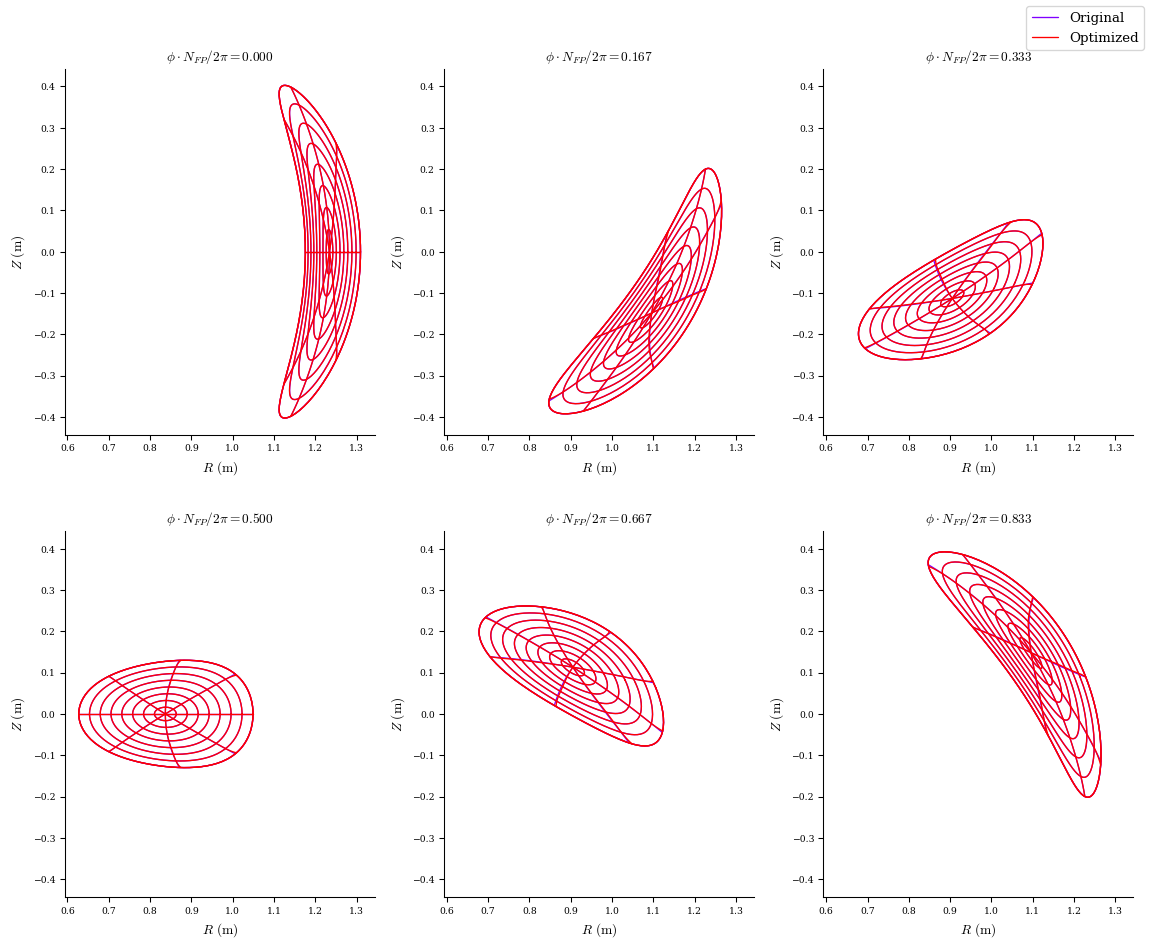

In [3]:
eq = get("precise_QA")
eq_org = eq.copy()

optimizer = Optimizer("proximal-lsq-exact")
# fix |m| <= "fix_modes" modes
fix_modes = 2
R_modes = eq.surface.R_basis.modes[
    np.max(np.abs(eq.surface.R_basis.modes), 1) > fix_modes, :
]
Z_modes = eq.surface.Z_basis.modes[
    np.max(np.abs(eq.surface.Z_basis.modes), 1) > fix_modes, :
]
constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),
    # ForceBalance(eq=eq),
)
objective = ObjectiveFunction(
    (
        BFieldErrorAtIslandSurface(eq=eq, rho=0.5), 
    )
)
eq.optimize(
    optimizer=optimizer,
    constraints=constraints,
    objective=objective,
    verbose=3,
    maxiter=100,
)

plot_comparison(eqs=[eq_org, eq], labels=["Original", "Optimized"]);
plt.savefig("test-precise-QA.png", dpi=500)

In [7]:
a = np.zeros((10,10))
print(a)
a[1,1] = 1e2
np.any(a>100)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


False

In [ ]:
from desc.magnetic_fields._core import B_from_surface_integral
import time

eq = get("precise_QA")

t0 = time.time()
grid_source = LinearGrid(rho=1, M=550, N=550, NFP=int(eq.NFP))
grid_eval = LinearGrid(rho=np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]), M=10, N=0, NFP=int(eq.NFP))

keys = [
    "K_vc",
    "|e_theta x e_zeta|",
    "R",
    "phi",
    "Z",
    "e^rho",
    "e^theta",
]
data_source = eq.compute(keys, grid=grid_source)
data_eval = eq.compute(keys, grid=grid_eval)

re = jnp.vstack((data_eval["R"], data_eval["phi"], data_eval["Z"])).T
rs = jnp.vstack((data_source["R"], data_source["phi"], data_source["Z"])).T
dA = grid_source.weights * data_source["|e_theta x e_zeta|"] / grid_source.NFP
K = data_source["K_vc"]
print(f"Setting parameters took: {time.time()-t0:.2f} seconds")

Bplasma2 = B_from_surface_integral(re, rs, K, eq.NFP, dA)  
scale = 2
fig,ax = plot_surfaces(eq,theta=0,rho=np.arange(0.1,1.01,0.1), phi=0.0,figsize=(8,8),lcfs_color="k")
ax[0].quiver(data_eval["R"],data_eval["Z"],data_eval["B"][:,0],data_eval["B"][:,2],
             label=r"$B_{eval-grid}$",scale=scale,color="r")
ax[0].quiver(data_eval["R"],data_eval["Z"],Bplasma2[:,0],Bplasma2[:,2],
             label=r"$B_{surface-integral}$",scale=scale,color="g")
ax[0].legend(fontsize=12)
fig=plt.gcf()

In [ ]:
from desc.magnetic_fields import field_line_integrate, ToroidalMagneticField
from desc.magnetic_fields._core import biot_savart_general
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz_vec
from desc.backend import jnp, fori_loop

def B_from_K_trace(re, params=None, basis="rpz",source_grid=grid_source):
    phi_re = re[:, 1]
    re = rpz2xyz(re)
    def nfp_loop(j, f):
        # calculate (by rotating) rs, rs_t, rz_t
        phi = (grid_source.nodes[:, 2] + j * 2 * jnp.pi / grid_source.NFP) % (
            2 * jnp.pi
        )
        # new coords are just old R,Z at a new phi (bc of discrete NFP symmetry)
        rs = jnp.vstack((_rs[:, 0], phi, _rs[:, 2])).T
        rs = rpz2xyz(rs)
        
        K = rpz2xyz_vec(_K, phi=phi)
        fj = biot_savart_general(
            re,
            rs,
            K,
            _dV,
        )
        f += fj
        return f

    Bplasma = fori_loop(0, grid_source.NFP, nfp_loop, jnp.zeros_like(re))
    Bplasma = xyz2rpz_vec(Bplasma, phi=phi_re)
    return Bplasma

grid_source = LinearGrid(rho=1, M=550, N=550, NFP=int(eq.NFP))

keys = [
    "K_vc",
    "|e_theta x e_zeta|",
    "R",
    "phi",
    "Z",
]
data_source = eq.compute(keys, grid=grid_source)
_rs = jnp.vstack((data_source["R"], data_source["phi"], data_source["Z"])).T
_dV = grid_source.weights * data_source["|e_theta x e_zeta|"] / grid_source.NFP
_K = data_source["K_vc"]

ntransit=50
n_R_points = 10

phis = np.arange(0, ntransit * 2 * np.pi, 2 * np.pi)
rrr = np.linspace(1.17,1.25,n_R_points) # initial R positions of field-lines to trace
Bfield = ToroidalMagneticField(1,1)
Bfield.compute_magnetic_field = B_from_K_trace
field_R, field_Z = field_line_integrate(rrr, np.zeros_like(rrr), phis, Bfield, source_grid=grid_source)